2.3.0+cu121 0.18.0+cu121
Running on cpu
Files already downloaded and verified


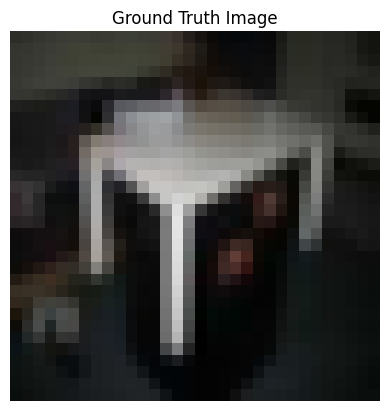

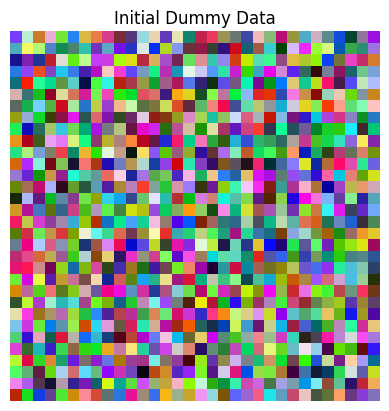

Iteration 0: Loss = 111.1009
Iteration 10: Loss = 3.5971
Iteration 20: Loss = 0.8980
Iteration 30: Loss = 0.2920
Iteration 40: Loss = 0.0770
Iteration 50: Loss = 0.0200
Iteration 60: Loss = 0.0068
Iteration 70: Loss = 0.0030
Iteration 80: Loss = 0.0012
Iteration 90: Loss = 0.0006
Iteration 100: Loss = 0.0003
Iteration 110: Loss = 0.0001
Iteration 120: Loss = 0.0001
Iteration 130: Loss = 0.0000
Iteration 140: Loss = 0.0000
Iteration 150: Loss = 0.0000
Iteration 160: Loss = 0.0000
Iteration 170: Loss = 0.0000
Iteration 180: Loss = 0.0000
Iteration 190: Loss = 0.0000
Iteration 200: Loss = 0.0000
Iteration 210: Loss = 0.0000
Iteration 220: Loss = 0.0000
Iteration 230: Loss = 0.0000
Iteration 240: Loss = 0.0000
Iteration 250: Loss = 0.0000
Iteration 260: Loss = 0.0000
Iteration 270: Loss = 0.0000
Iteration 280: Loss = 0.0000
Iteration 290: Loss = 0.0000
Iteration 300: Loss = 0.0000
Iteration 310: Loss = 0.0000
Iteration 320: Loss = 0.0000
Iteration 330: Loss = 0.0000
Iteration 340: Loss = 0

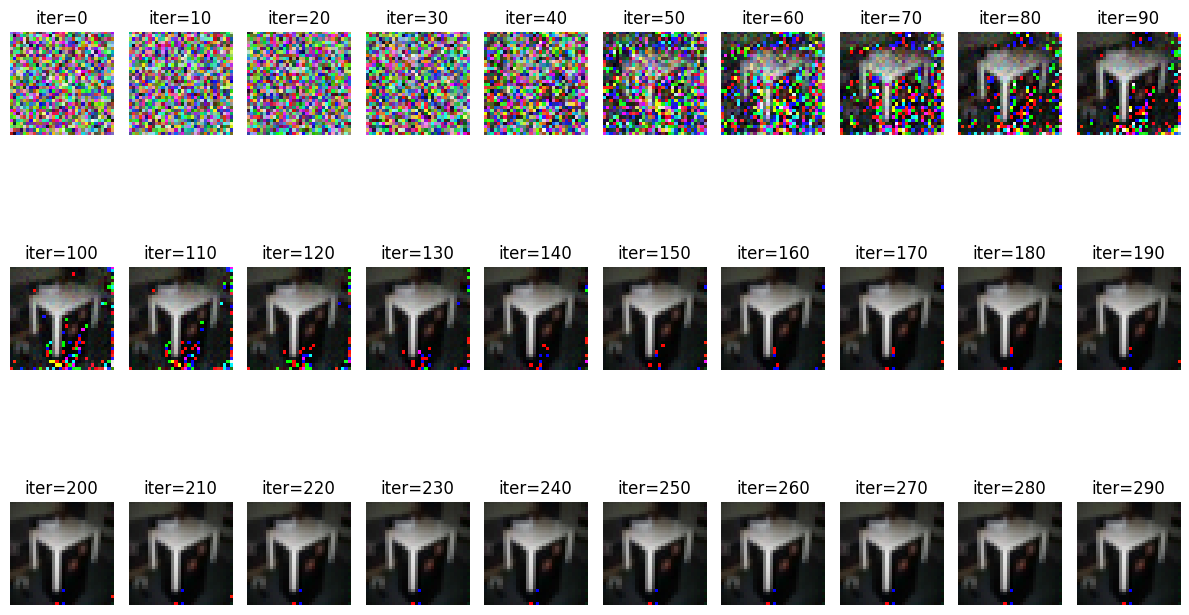

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
        
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=2),
            act(),
            nn.Conv2d(12, 12, kernel_size=5, padding=5//2, stride=1),
            act(),
        )
        self.fc = nn.Sequential(
            nn.Linear(768, 100)
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        # print(out.size())
        out = self.fc(out)
        return out


'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.Sigmoid(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.Sigmoid(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.Sigmoid(self.bn1(self.conv1(x)))
        out = F.Sigmoid(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.Sigmoid(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.Sigmoid(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])



# -*- coding: utf-8 -*-
import torch
import torch.nn.functional as F


def label_to_onehot(target, num_classes=100):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))
# -*- coding: utf-8 -*-
import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import torchvision
from torchvision import models, datasets, transforms

print(torch.__version__, torchvision.__version__)



# Replace argparse with direct inputs
img_index = 25  # Replace with your desired index
custom_image_path = ""  # Replace with your custom image path, or leave as "" to use CIFAR-100

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

# Load CIFAR-100 dataset
dst = datasets.CIFAR100("~/.torch", download=True)
tp = transforms.ToTensor()
tt = transforms.ToPILImage()

# Load ground truth data
gt_data = tp(dst[img_index][0]).to(device)

# If a custom image path is provided, load it instead
if len(custom_image_path) > 1:
    gt_data = Image.open(custom_image_path)
    gt_data = tp(gt_data).to(device)

gt_data = gt_data.view(1, *gt_data.size())
gt_label = torch.Tensor([dst[img_index][1]]).long().to(device)
gt_label = gt_label.view(1,)
gt_onehot_label = label_to_onehot(gt_label)

# Display the ground truth image
plt.imshow(tt(gt_data[0].cpu()))
plt.title("Ground Truth Image")
plt.axis('off')
plt.show()

# Load the LeNet model
net = LeNet().to(device)

# Initialize the model weights
torch.manual_seed(1234)
net.apply(weights_init)
criterion = cross_entropy_for_onehot

# Compute the original gradient
pred = net(gt_data)
y = criterion(pred, gt_onehot_label)
dy_dx = torch.autograd.grad(y, net.parameters())

original_dy_dx = list((_.detach().clone() for _ in dy_dx))

# Generate dummy data and label
dummy_data = torch.randn(gt_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(gt_onehot_label.size()).to(device).requires_grad_(True)

# Display the initial dummy data
plt.imshow(tt(dummy_data[0].cpu()))
plt.title("Initial Dummy Data")
plt.axis('off')
plt.show()

# Optimizer
optimizer = torch.optim.LBFGS([dummy_data, dummy_label],lr=0.1)

# Training loop
history = []
for iters in range(500):
    def closure():
        optimizer.zero_grad()

        dummy_pred = net(dummy_data) 
        dummy_onehot_label = F.softmax(dummy_label, dim=-1)
        dummy_loss = criterion(dummy_pred, dummy_onehot_label) 
        dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
        
        grad_diff = 0
        for gx, gy in zip(dummy_dy_dx, original_dy_dx): 
            grad_diff += ((gx - gy) ** 2).sum()
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 10 == 0: 
        current_loss = closure()
        print(f"Iteration {iters}: Loss = {current_loss.item():.4f}")
        history.append(tt(dummy_data[0].cpu()))

# Display the results
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(history[i])
    plt.title(f"iter={i * 10}")
    plt.axis('off')

plt.tight_layout()
plt.show()